<a href="https://colab.research.google.com/github/maossand/packed_fruits/blob/main/packed_fruit_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install -q kaggle

In [1]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [5]:
# #-p specifies the path
# path = 'content/drive/MyDrive/packed_fruits/fruit_packed_data/'
# !kaggle datasets download -d sergeynesteruk/packed-fruits-and-vegetables-recognition-benchmark -p /content/drive/MyDrive/packed_fruits/fruit_packed_data/


Dataset URL: https://www.kaggle.com/datasets/sergeynesteruk/packed-fruits-and-vegetables-recognition-benchmark
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 29.2G/29.2G [04:19<00:00, 33.9MB/s]
100% 29.2G/29.2G [04:19<00:00, 121MB/s] 


In [7]:
# import zipfile

# # Specify the correct path
# zip_file_path = '/content/drive/MyDrive/packed_fruits/fruit_packed_data/packed-fruits-and-vegetables-recognition-benchmark.zip'
# extract_to_path = '/content/drive/MyDrive/packed_fruits/fruit_packed_data/'
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_path)


In [ ]:
# !unzip /content/packed-fruits-and-vegetables-recognition-benchmark.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train/train/tomato_slivka/076841.jpg  
  inflating: train/train/tomato_slivka/076918.jpg  
  inflating: train/train/tomato_slivka/076945.jpg  
  inflating: train/train/tomato_slivka/077027.jpg  
  inflating: train/train/tomato_slivka/077040.jpg  
  inflating: train/train/tomato_slivka/077047.jpg  
  inflating: train/train/tomato_slivka/077083.jpg  
  inflating: train/train/tomato_slivka/077099.jpg  
  inflating: train/train/tomato_slivka/077215.jpg  
  inflating: train/train/tomato_slivka/077428.jpg  
  inflating: train/train/tomato_slivka/077475.jpg  
  inflating: train/train/tomato_slivka/077548.jpg  
  inflating: train/train/tomato_slivka/077610.jpg  
  inflating: train/train/tomato_slivka/077639.jpg  
  inflating: train/train/tomato_slivka/077715.jpg  
  inflating: train/train/tomato_slivka/077722.jpg  
  inflating: train/train/tomato_slivka/078018.jpg  
  inflating: train/train/tomato_slivka

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


In [1]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/packed_fruits/fruit_packed_data/')


Mounted at /content/drive


NameError: name 'os' is not defined

#Import Classification DF

In [188]:
#Import classification df

#Force the 8th column to string to avoid error

dtype = {7: str}

#Import csv

classification_df = pd.read_csv('variety_classification.csv', dtype=dtype)

###General Cleaning

#Create a working file path for the folders
classification_df['new_path'] = (classification_df['subset'].astype(str) + '/'
                                +classification_df['subset'].astype(str) + '/'
                                + classification_df['subset'].astype(str) + '_'
                                + classification_df['species'].astype(str) + '_'
                                + classification_df['variety'].astype(str) + '/'
                                + classification_df['variety_image_path'].apply(lambda x: str(x).split('/')[-1]))
classification_df.drop(columns=['variety_image_path'], inplace=True)

#Create a column with the file name
classification_df['file_name'] = classification_df['new_path'].apply(lambda x: str(x).split('/')[-1])

#Clean variable names and column name to avoid conflict with the class 'class'
classification_df['fruit_class'] = classification_df['class'].apply(lambda x:
  str(x).replace(' ', '_').replace('(', '').replace(')', ''))
classification_df.drop(columns=['class'], inplace=True)

#Change variables type
classification_df['layout_id'] = classification_df['layout_id'].astype('str')
classification_df['cam'] = classification_df['cam'].astype('str')
classification_df['shop'] = classification_df['shop'].astype('str')
classification_df['date'] = classification_df['date'].astype('str')

#Clean whitespaces in str variables

classification_df[classification_df.select_dtypes('object').columns] = classification_df.select_dtypes('object').apply(lambda x: x.str.strip() if x.dtype == "object" else x)

#Set everything to lowercase

classification_df[classification_df.select_dtypes('object').columns] = classification_df.select_dtypes('object').apply(lambda x: x.str.strip().str.lower() if x.dtype == "object" else x)



## Cleaning Date Column

In [186]:
#classification_df.groupby('date').count()

#The format looks really messy, we are interested in the year and month, let's extract those.

#The format looks really messy, we are interested in the year and month, let's extract those.
classification_df['date'] = classification_df['date'].str.replace('-', '/').str.replace('.', '/').str.replace(';','/')
classification_df['date'] = classification_df['date'].str.replace('0202','2022')
classification_df['date'] = classification_df['date'].str.replace(' may ', '/05/')
classification_df['date'] = classification_df['date'].str.replace(' june ', '/06/')


# Convert Excel serial dates (e.g., '44741') if the string starts with '447' and return as 'YYYY/MM/DD' format
classification_df['date'] = classification_df['date'].apply(lambda row: (pd.to_datetime('1899-12-30') + pd.to_timedelta(float(row), unit='D')).strftime('%Y/%m/%d')
                                         if isinstance(row, str) and row.startswith('447') else row)
#Data was collected in 2022
classification_df['year'] = classification_df['date'].apply(lambda row: '2022' if '2022' in row else 0)

#Extracting Months
classification_df['month'] = classification_df['date'].apply(lambda row: row.split('/')[1] if len(row.split('/')) > 1 else 0)
classification_df['month'] = classification_df['month'].astype('str').apply(lambda row: '0' + row if len(row) == 1 else row)

#Extracting Days
classification_df['day'] = classification_df['date'].apply(
    lambda x: x.split('/', 2)[2][:2] if len(x.split('/', 2)[0]) > 2 and len(x.split('/', 2)) > 2
    else x.split('/', 2)[0] if len(x.split('/', 2)[0]) <= 2 else '0'
)
classification_df['day'] = classification_df['day'].astype('str').apply(lambda row: '0' + row if len(row) == 1 else row)


classification_df['full_date'] = classification_df['year'].astype('str') + '-' + classification_df['month'] + '-' + classification_df['day']
classification_df['full_date'] = pd.to_datetime(classification_df['full_date'], errors='coerce')

classification_df.drop(columns=['date'], inplace=True)



In [189]:
classification_df

,species,variety,layout_id,for_cropping,packed,amount,weight,uniform_background,spoiled,cam,city,shop,crowd,date,subset,simp_amount,new_path,file_name,fruit_class
0,apple,fuji,1246,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,train/train/train_apple_fuji/007576.jpg,007576.jpg,apple_fuji
1,apple,fuji,1246,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,train/train/train_apple_fuji/085095.jpg,085095.jpg,apple_fuji
2,apple,fuji,1246,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,train/train/train_apple_fuji/077142.jpg,077142.jpg,apple_fuji
3,apple,fuji,1246,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,train/train/train_apple_fuji/091219.jpg,091219.jpg,apple_fuji
4,apple,fuji,4610,0,1,5,776,0,0,42,spb,113,1,2022-06-10 00:00:00,test,4-6,test/test/test_apple_fuji/019846.jpg,019846.jpg,apple_fuji
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103407,zucchini,white,0,0,1,7,2171.0,0,0,97,gatchina,97,1,2022-07-02 00:00:00,train,7+,train/train/train_zucchini_white/048905.jpg,048905.jpg,zucchini_white
103408,zucchini,white,22024,0,1,7,2174.0,0,0,97,gatchina,97,1,2022-07-02 00:00:00,train,7+,train/train/train_zucchini_white/082386.jpg,082386.jpg,zucchini_white
103409,zucchini,white,22024,0,1,7,2174.0,0,0,97,gatchina,97,1,2022-07-02 00:00:00,train,7+,train/train/train_zucchini_white/034988.jpg,034988.jpg,zucchini_white
103410,zucchini,white,22024,0,1,7,2174.0,0,0,97,gatchina,97,1,2022-07-02 00:00:00,train,7+,train/train/train_zucchini_white/007805.jpg,007805.jpg,zucchini_white


# EDA

In [ ]:
#Fruits

In [ ]:
#Layout ID

In [ ]:
#Packed

In [144]:
classification_df[classification_df['layout_id'] == '0']

,species,variety,layout_id,for_cropping,packed,amount,weight,uniform_background,spoiled,cam,...,crowd,subset,simp_amount,new_path,file_name,fruit_class,year,month,day,full_date
12,apple,fuji,0,0,1,5,776,0,0,42,...,0,train,4-6,train/train_apple_fuji/083671.jpg,083671.jpg,apple_fuji,2022,06,10,2022-06-10
13,apple,fuji,0,0,1,5,776,0,0,42,...,0,train,4-6,train/train_apple_fuji/035787.jpg,035787.jpg,apple_fuji,2022,06,10,2022-06-10
14,apple,fuji,0,0,1,5,776,0,0,42,...,0,train,4-6,train/train_apple_fuji/086755.jpg,086755.jpg,apple_fuji,2022,06,10,2022-06-10
31,apple,fuji,0,0,1,4,620,0,0,42,...,0,train,4-6,train/train_apple_fuji/001414.jpg,001414.jpg,apple_fuji,2022,06,10,2022-06-10
32,apple,fuji,0,0,1,4,620,0,0,42,...,0,train,4-6,train/train_apple_fuji/030463.jpg,030463.jpg,apple_fuji,2022,06,10,2022-06-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103403,zucchini,white,0,0,1,7,2187.0,0,0,97,...,1,train,7+,train/train_zucchini_white/010791.jpg,010791.jpg,zucchini_white,2022,07,02,2022-07-02
103404,zucchini,white,0,0,1,7,2171.0,0,0,97,...,1,train,7+,train/train_zucchini_white/067847.jpg,067847.jpg,zucchini_white,2022,07,02,2022-07-02
103405,zucchini,white,0,0,1,7,2171.0,0,0,97,...,1,train,7+,train/train_zucchini_white/039971.jpg,039971.jpg,zucchini_white,2022,07,02,2022-07-02
103406,zucchini,white,0,0,1,7,2171.0,0,0,97,...,1,train,7+,train/train_zucchini_white/000148.jpg,000148.jpg,zucchini_white,2022,07,02,2022-07-02


In [154]:
# Filter out rows where layout_id == 0
filtered_df = classification_df[classification_df['layout_id'] != '0']

# Group by 'fruit_class' and count unique 'layout_id's
result = filtered_df.groupby(['fruit_class','layout_id'])['layout_id'].count()

# Display the result
print(result)

fruit_class     layout_id
apple_fuji      1246         4
                19253        4
                19254        4
                19255        4
                19256        4
                            ..
zucchini_white  9693         4
                9694         4
                9695         4
                9696         4
                9697         4
Name: layout_id, Length: 22140, dtype: int64


In [156]:
classification_df[classification_df['for_cropping'] == 1]

,species,variety,layout_id,for_cropping,packed,amount,weight,uniform_background,spoiled,cam,...,crowd,subset,simp_amount,new_path,file_name,fruit_class,year,month,day,full_date
346,apple,fuji,0,1,0,0,NaN,0,0,44,...,1,train,2-3,train/train_apple_fuji/003886.jpg,003886.jpg,apple_fuji,2022,07,06,2022-07-06
347,apple,fuji,0,1,0,0,NaN,0,0,44,...,1,train,2-3,train/train_apple_fuji/036348.jpg,036348.jpg,apple_fuji,2022,07,06,2022-07-06
348,apple,fuji,0,1,0,0,NaN,0,1,44,...,1,train,2-3,train/train_apple_fuji/014910.jpg,014910.jpg,apple_fuji,2022,07,06,2022-07-06
349,apple,fuji,0,1,0,0,NaN,0,0,44,...,1,train,2-3,train/train_apple_fuji/043406.jpg,043406.jpg,apple_fuji,2022,07,06,2022-07-06
350,apple,fuji,0,1,0,0,NaN,0,1,44,...,1,train,2-3,train/train_apple_fuji/016511.jpg,016511.jpg,apple_fuji,2022,07,06,2022-07-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102927,zucchini,white,0,1,0,0,NaN,0,0,97,...,0,train,2-3,train/train_zucchini_white/011327.jpg,011327.jpg,zucchini_white,2022,07,02,2022-07-02
102928,zucchini,white,0,1,0,0,NaN,0,0,97,...,0,train,2-3,train/train_zucchini_white/075860.jpg,075860.jpg,zucchini_white,2022,07,02,2022-07-02
102929,zucchini,white,0,1,0,0,NaN,0,0,97,...,0,train,2-3,train/train_zucchini_white/102420.jpg,102420.jpg,zucchini_white,2022,07,02,2022-07-02
102930,zucchini,white,0,1,0,0,NaN,0,0,97,...,0,train,2-3,train/train_zucchini_white/078310.jpg,078310.jpg,zucchini_white,2022,07,02,2022-07-02


In [137]:
# # #The format looks really messy, we are interested in the year and month, let's extract those.
# # date_df = classification_df[['date']].copy()
# # date_df['date'] = date_df['date'].str.replace('-', '/').str.replace('.', '/').str.replace(';','/')
# # date_df['date'] = date_df['date'].str.replace('0202','2022')
# # date_df['date'] = date_df['date'].str.replace(' may ', '/05/')
# # date_df['date'] = date_df['date'].str.replace(' june ', '/06/')
# # date_df['is_clean'] = 0
# # date_df['has_month'] = 0
# # date_df['has_year'] = 0

# # # Convert Excel serial dates (e.g., '44741') if the string starts with '447' and return as 'YYYY/MM/DD' format
# # date_df['date'] = date_df['date'].apply(lambda row: (pd.to_datetime('1899-12-30') + pd.to_timedelta(float(row), unit='D')).strftime('%Y/%m/%d')
# #                                          if isinstance(row, str) and row.startswith('447') else row)
# # #Data was collected in 2022
# # date_df['year'] = date_df['date'].apply(lambda row: '2022' if '2022' in row else 0)

# # #Extracting Months
# # date_df['month'] = date_df['date'].apply(lambda row: row.split('/')[1] if len(row.split('/')) > 1 else 0)
# # date_df['month'] = date_df['month'].astype('str').apply(lambda row: '0' + row if len(row) == 1 else row)

# # #Extracting Days
# # date_df['day'] = date_df['date'].apply(
# #     lambda x: x.split('/', 2)[2][:2] if len(x.split('/', 2)[0]) > 2 and len(x.split('/', 2)) > 2
# #     else x.split('/', 2)[0] if len(x.split('/', 2)[0]) <= 2 else '0'
# # )
# # date_df['day'] = date_df['day'].astype('str').apply(lambda row: '0' + row if len(row) == 1 else row)


# # date_df['full_date'] = date_df['year'].astype('str') + '-' + date_df['month'] + '-' + date_df['day']
# # date_df['full_date'] = pd.to_datetime(date_df['full_date'], errors='coerce')

# date_df['has_year'] = date_df['year'].apply(lambda x: 1 if pd.notna(x) and x != 0 else 0)
# date_df['has_month'] = date_df['month'].apply(lambda x: 1 if pd.notna(x) and x != 0 else 0)
# date_df['is_clean'] = date_df.apply(lambda row: 1 if row['has_year'] == 1 and row['has_month'] == 1 else 0, axis=1)

# date_df[date_df['has_year'] == 0].groupby('date').count()



# EDA

In [ ]:
print(classification_df.shape)
print(classification_df.columns)

(103412, 19)

In [ ]:
classification_df.head(20)

,species,variety,layout_id,for_cropping,packed,amount,weight,uniform_background,spoiled,cam,city,shop,crowd,date,subset,simp_amount,fruit_class,new_path
0,apple,fuji,1246,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,apple (fuji),train/train_apple_fuji/007576.jpg
1,apple,fuji,1246,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,apple (fuji),train/train_apple_fuji/085095.jpg
2,apple,fuji,1246,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,apple (fuji),train/train_apple_fuji/077142.jpg
3,apple,fuji,1246,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,apple (fuji),train/train_apple_fuji/091219.jpg
4,apple,fuji,4610,0,1,5,776,0,0,42,spb,113,1,2022-06-10 00:00:00,test,4-6,apple (fuji),test/test_apple_fuji/019846.jpg
5,apple,fuji,4610,0,1,5,776,0,0,42,spb,113,1,2022-06-10 00:00:00,test,4-6,apple (fuji),test/test_apple_fuji/077654.jpg
6,apple,fuji,4610,0,1,5,776,0,0,42,spb,113,1,2022-06-10 00:00:00,test,4-6,apple (fuji),test/test_apple_fuji/020223.jpg
7,apple,fuji,4610,0,1,5,776,0,0,42,spb,113,1,2022-06-10 00:00:00,test,4-6,apple (fuji),test/test_apple_fuji/029927.jpg
8,apple,fuji,19344,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,apple (fuji),train/train_apple_fuji/045194.jpg
9,apple,fuji,19344,0,1,5,776,0,0,42,spb,113,0,2022-06-10 00:00:00,train,4-6,apple (fuji),train/train_apple_fuji/055181.jpg


In [ ]:
classification_df['simp_amount'].value_counts()

simp_amount
2-3    34326
4-6    24987
1      23568
7+     20531
Name: count, dtype: int64

In [ ]:
classification_df.packed.value_counts()

packed
0    55969
1    47443
Name: count, dtype: int64

In [ ]:
print("Unique species (eg pomme):", classification_df.species.nunique())
print("Unique varieties (eg fuji):", classification_df.variety.nunique())
print("Species-variety combination (eg pomme-fuji):",classification_df[['species','variety']].value_counts().shape[0],".")
print("")
print("Min number of images for species-variety combination (eg pomme-fuji):",classification_df.groupby(['species','variety'])['variety'].count().min(),".")
print("Max number of images for species-variety combination (eg pomme-fuji):",classification_df.groupby(['species','variety'])['variety'].count().max(),".")
print("")
print("Min number of images per species (eg pomme):",classification_df['species'].value_counts().min(),".")
print("Max number of images per species (eg pomme):",classification_df['species'].value_counts().max(),".")


Unique species (eg pomme): 34
Unique varieties (eg fuji): 49
Species-variety combination (eg pomme-fuji): 65 .

Min number of images for species-variety combination (eg pomme-fuji): 405 .
Max number of images for species-variety combination (eg pomme-fuji): 2495 .

Min number of images per species (eg pomme): 405 .
Max number of images per species (eg pomme): 11879 .


In [ ]:
class_nums = pd.factorize(classification_df['fruit_class'])[0]
class_nums

array([ 0,  0,  0, ..., 64, 64, 64])

In [193]:
# prompt: check my location in drive

import os
base_path = os.getcwd()
base_path

'/content/drive/MyDrive/packed_fruits/fruit_packed_data'

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/packed_fruits/fruit_packed_data/train/train/train_grape_green/053685.jpg'

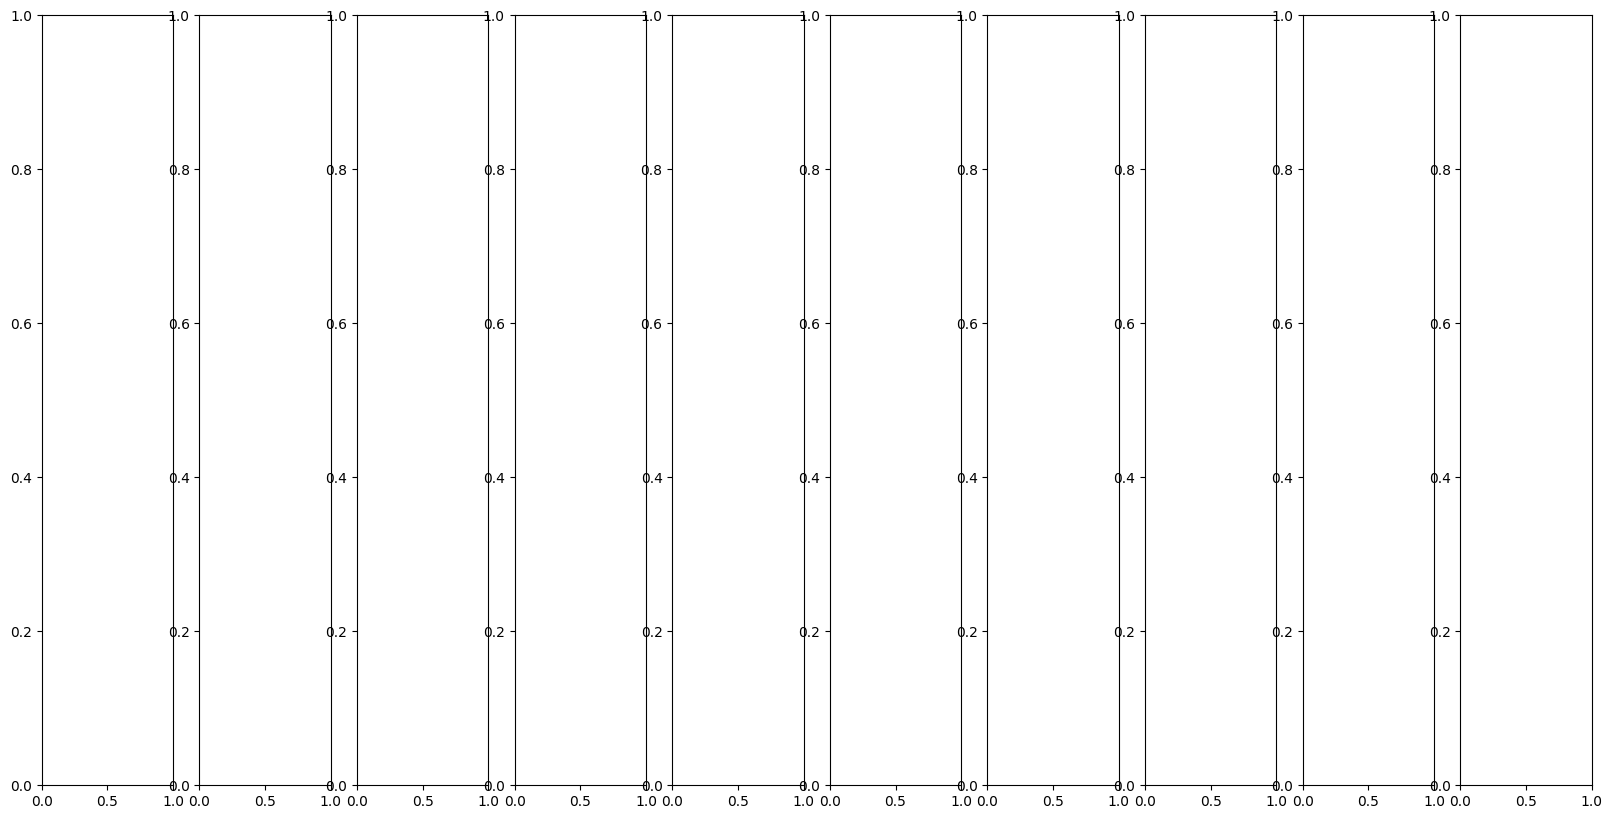

In [194]:
# Look at some images

import random
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, 10, figsize=(20, 10))


for i in range(10):

    random_number = random.randint(0, classification_df.shape[0])

    # file_name = str(df_filtered['variety_image_path'].iloc[random_number]).split("/")[-1]
    # subset_folder = str(df_filtered['subset'].iloc[random_number])
    # species = str(df_filtered['species'].iloc[random_number])
    # variety = str(df_filtered['variety'].iloc[random_number])
    base_path = os.getcwd()
    path_to_image = str(classification_df['new_path'].iloc[random_number])
    path_full = os.path.join(base_path, path_to_image)
    image = mpimg.imread(path_full)

    plt.subplot(1,10,i+1)

    plt.imshow(image)

    plt.axis('off')

    plt.title(str(classification_df['fruit_class'].iloc[random_number]), fontdict={'color' : 'Black', 'fontsize': 10})

plt.show()

## Pommes & Poivrons

In [ ]:
#For now we will work with apple_fuji (red), apple_granny (green), pepper_sweet_green (green), pepper_sweet_red (red)

df_pompov = classification_df[((classification_df['species'] == 'apple') &
                            ((classification_df['variety'] =='fuji') | (classification_df['variety'] =='granny'))) |
                            ((classification_df['species'] == 'pepper') &
                            ((classification_df['variety'] =='sweet_green') | (classification_df['variety'] =='sweet_red')))]

#And we will start with the non_packed images, with uniform background, in good condition, and no more than 3 fruits per picture

df_filtered = df_pompov[(df_pompov['packed'] == 0) &
                        (df_pompov['uniform_background'] == 1) &
                        (df_pompov['spoiled'] == 0) &
                        (df_pompov['amount'] < 4)]

In [ ]:
print("Shape:",df_filtered.shape)
print("Test-train images:\n",df_filtered.subset.value_counts())

Shape: (820, 18)
Test-train images:
 subset
train    650
test     170
Name: count, dtype: int64


In [ ]:
df_filtered.variety.value_counts()

variety
sweet_green    283
granny         282
sweet_red      176
fuji            79
Name: count, dtype: int64

In [ ]:
df_filtered.head()

,species,variety,layout_id,for_cropping,packed,amount,weight,uniform_background,spoiled,cam,city,shop,crowd,date,subset,simp_amount,fruit_class,new_path
307,apple,fuji,19359,0,0,1,155,1,0,43,spb,113,0,2022-07-06 00:00:00,test,1,apple (fuji),test/test_apple_fuji/048985.jpg
308,apple,fuji,19359,0,0,1,155,1,0,43,spb,113,0,2022-07-06 00:00:00,test,1,apple (fuji),test/test_apple_fuji/018739.jpg
309,apple,fuji,19359,0,0,1,155,1,0,43,spb,113,0,2022-07-06 00:00:00,test,1,apple (fuji),test/test_apple_fuji/080048.jpg
310,apple,fuji,19359,0,0,1,155,1,0,43,spb,113,0,2022-07-06 00:00:00,test,1,apple (fuji),test/test_apple_fuji/060537.jpg
311,apple,fuji,19358,0,0,2,310,1,0,43,spb,113,0,2022-07-06 00:00:00,test,2-3,apple (fuji),test/test_apple_fuji/005326.jpg


In [ ]:
df_filtered[df_filtered['layout_id'] == 19257]

,species,variety,layout_id,for_cropping,packed,amount,weight,uniform_background,spoiled,cam,city,shop,crowd,date,subset,simp_amount,fruit_class,new_path
526,apple,fuji,19257,0,0,1,240,1,0,68,spb,68,0,2022-06-14 00:00:00,train,1,apple (fuji),train/train_apple_fuji/081840.jpg
527,apple,fuji,19257,0,0,1,240,1,0,68,spb,68,0,2022-06-14 00:00:00,train,1,apple (fuji),train/train_apple_fuji/052989.jpg
528,apple,fuji,19257,0,0,1,240,1,0,68,spb,68,0,2022-06-14 00:00:00,train,1,apple (fuji),train/train_apple_fuji/041908.jpg
529,apple,fuji,19257,0,0,1,240,1,0,68,spb,68,0,2022-06-14 00:00:00,train,1,apple (fuji),train/train_apple_fuji/069055.jpg


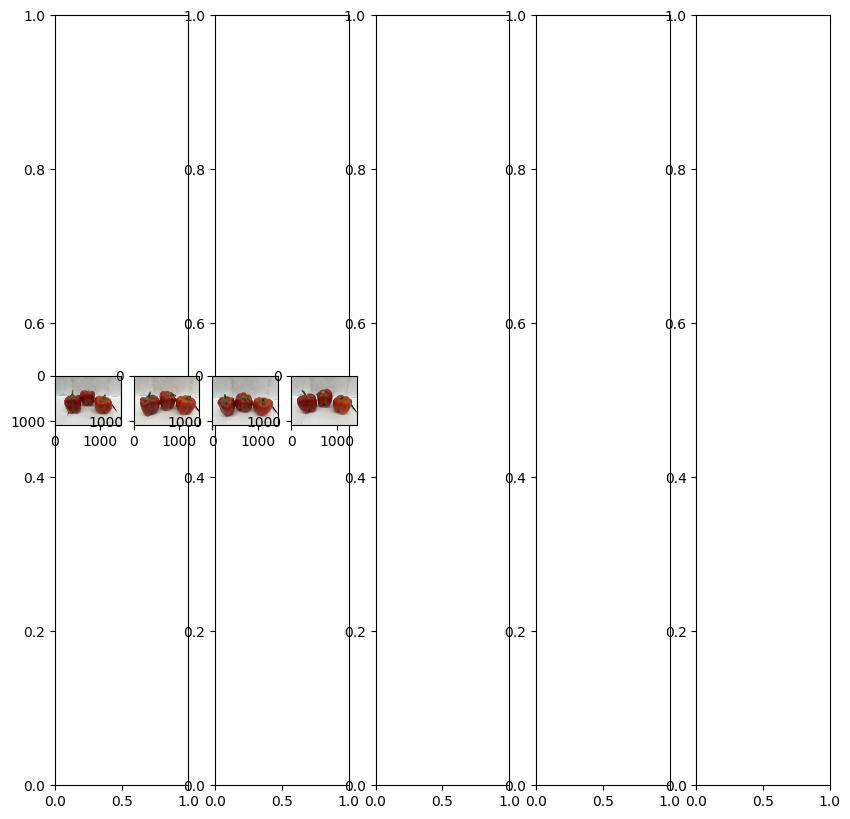

In [ ]:
# fig, axes = plt.subplots(1, 5, figsize=(10, 10))

# path_to_image = str(df_filtered['new_path'].iloc[526])
# image = mpimg.imread(path_to_image)
# plt.subplot(1,10,1)
# plt.imshow(image)

# path_to_image = str(df_filtered['new_path'].iloc[527])
# image = mpimg.imread(path_to_image)
# plt.subplot(1,10,2)
# plt.imshow(image)

# path_to_image = str(df_filtered['new_path'].iloc[528])
# image = mpimg.imread(path_to_image)
# plt.subplot(1,10,3)
# plt.imshow(image)

# path_to_image = str(df_filtered['new_path'].iloc[529])
# image = mpimg.imread(path_to_image)
# plt.subplot(1,10,4)
# plt.imshow(image)

### Random Images

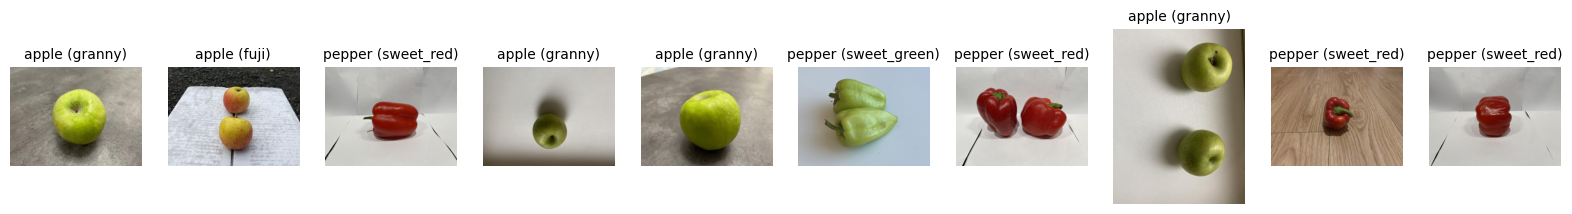

In [ ]:
# Look at some images

import random
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, 10, figsize=(20, 10))


for i in range(10):

    random_number = random.randint(0, df_filtered.shape[0])

    # file_name = str(df_filtered['variety_image_path'].iloc[random_number]).split("/")[-1]
    # subset_folder = str(df_filtered['subset'].iloc[random_number])
    # species = str(df_filtered['species'].iloc[random_number])
    # variety = str(df_filtered['variety'].iloc[random_number])

    path_to_image = str(df_filtered['new_path'].iloc[random_number])

    image = mpimg.imread(path_to_image)

    plt.subplot(1,10,i+1)

    plt.imshow(image)

    plt.axis('off')

    plt.title(str(df_filtered['fruit_class'].iloc[random_number]), fontdict={'color' : 'Black', 'fontsize': 10})

plt.show()

## By layout ID

In [ ]:
layout_count = df_filtered.groupby(['fruit_class','layout_id'])['layout_id'].count()

In [ ]:
layout_count

fruit_class         layout_id
apple (fuji)        0            10
                    19257         4
                    19258         4
                    19259         4
                    19260         2
                                 ..
pepper (sweet_red)  1239          4
                    1240          4
                    1241          4
                    1242          4
                    1243          4
Name: layout_id, Length: 205, dtype: int64

In [ ]:
df_filtered.layout_id.nunique()

203

In [ ]:
layout_id = {id for id in df_filtered.layout_id}

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

path_to_image = str(df_filtered['new_path'].iloc[random_number])
image = mpimg.imread(path_to_image)
plt.subplot(1,10,1)
plt.imshow(image)

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(20, 10))

layout_id =

for i in range(10):

    random_number = random.randint(0, df_filtered.shape[0])

    path_to_image = str(df_filtered['new_path'].iloc[random_number])

    image = mpimg.imread(path_to_image)

    plt.subplot(1,10,i+1)

    plt.imshow(image)

    plt.axis('off')

    plt.title(str(df_filtered['fruit_class'].iloc[random_number]), fontdict={'color' : 'Black', 'fontsize': 10})

plt.show()

# Model Building

In [ ]:
#Simple model to distinguish between apples and peppers

df_model = df_filtered[['new_path','species']]
#apple = 1, pepper = 0
df_model.loc[:, 'species'] = df_model['species'].apply(lambda x: str(1) if x == 'apple' else str(0))
df_model.species.value_counts()

species
0    459
1    361
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_model,
                                test_size=.2,
                                stratify=df_model['species'])

In [ ]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (656, 2)
X_test: (164, 2)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Normalize pixels to 0-1
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col='new_path',
    y_col='species',
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='binary',
    shuffle=True          # Whether to shuffle the data before each epoch
)

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='new_path',
    y_col='species',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 656 validated image filenames belonging to 2 classes.
Found 164 validated image filenames belonging to 2 classes.


## 1. Simple Model

In [ ]:
# Model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output for binary classification

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to see the details
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │    11,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,215,873 (42.79 MB)

 Trainable params: 11,215,873 (42.79 MB)

 Non-trainable params: 0 (0.00 B)

### Simple Model Training

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=2000 // 32,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=800 // 32)

Epoch 1/15
21/62 ━━━━━━━━━━━━━━━━━━━━ 14s 360ms/step - accuracy: 0.9824 - loss: 0.0567

/Users/martinoalonso/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9809 - loss: 0.0574 - val_accuracy: 0.9817 - val_loss: 0.0583
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9886 - loss: 0.0362 - val_accuracy: 0.9939 - val_loss: 0.0344
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9942 - loss: 0.0257 - val_accuracy: 0.9878 - val_loss: 0.0432
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9985 - loss: 0.0223 - val_accuracy: 0.9878 - val_loss: 0.0445
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9965 - loss: 0.0171 - val_accuracy: 0.9817 - val_loss: 0.0695
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.9942 - loss: 0.0183 - val_accuracy: 0.9878 - val_loss: 0.0353
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9968 - loss: 0.0170 - val_accuracy: 0.9817 - val_loss: 0.0306
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.9948 - loss: 0.0152 - val_accuracy: 0.9756 - 

In [ ]:
# Accessing the history dictionary
history_dict = history.history

# Printing training and validation metrics
print("Training Metrics:")
for key in history_dict:
    if 'val' not in key:
        print(f"{key}: {history_dict[key]}")

print("\nValidation Metrics:")
for key in history_dict:
    if 'val' in key:
        print(f"{key}: {history_dict[key]}")



Training Metrics:
accuracy: [0.6692073345184326, 0.8810975551605225, 0.9344512224197388, 0.9588414430618286, 0.9725610017776489, 0.9725610017776489, 0.9634146094322205, 0.9756097793579102, 0.9893292784690857, 0.9847561120986938, 0.9725610017776489, 0.9771341681480408, 0.9756097793579102, 0.9832317233085632, 0.9862805008888245]
loss: [1.7871532440185547, 0.2785044312477112, 0.1678074151277542, 0.11236532777547836, 0.09180375933647156, 0.07905852794647217, 0.08468886464834213, 0.06492685526609421, 0.044503577053546906, 0.048333629965782166, 0.06740671396255493, 0.05253981798887253, 0.06456224620342255, 0.055330660194158554, 0.049568530172109604]

Validation Metrics:
val_accuracy: [0.8231707215309143, 0.8963414430618286, 0.957317054271698, 0.9634146094322205, 0.9329268336296082, 0.9634146094322205, 0.9451219439506531, 0.9817073345184326, 0.9695122241973877, 0.9756097793579102, 0.957317054271698, 0.9817073345184326, 0.9634146094322205, 0.9085366129875183, 0.9634146094322205]
val_loss: [0.3

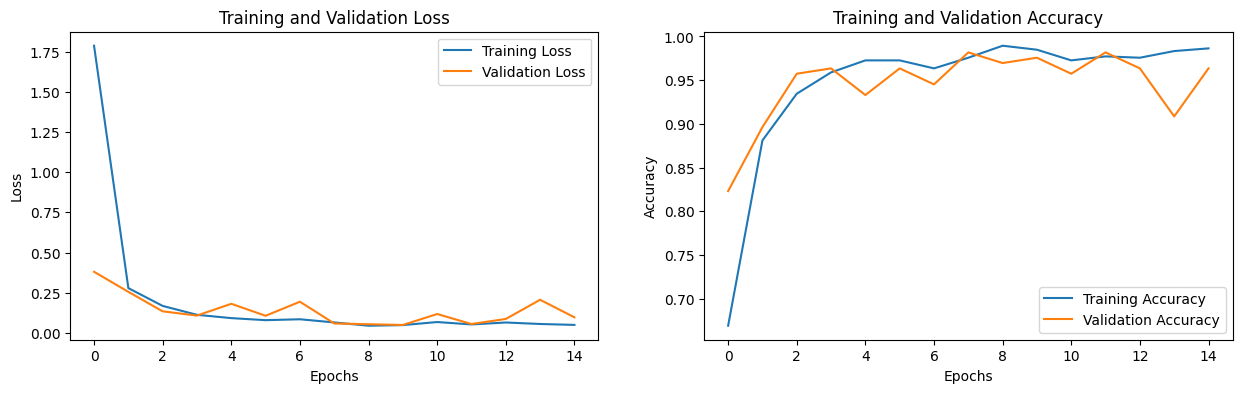

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 4))


# Plotting training and validation loss
plt.subplot(1,2,1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1,2,2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Simple Model Evaluation

### Medium Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(1, activation='sigmoid'))


### Complex Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:

#Build model

model = Sequential()

## Input Layer: Specify the input shape (150, 150, 3 for RGB images)

model.add(Input(shape=(150, 150, 3)))

# First Convolutional Layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten the output of the previous layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(64, activation='relu'))

# Dropout to prevent overfitting
model.add(Dropout(0.5))

# Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to see the details
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,212,513 (4.63 MB)

 Trainable params: 1,212,513 (4.63 MB)

 Non-trainable params: 0 (0.00 B)